## Construct a potential from a custom density function

We need to create potentials for these two distributions:

![notebook_data/pic1.png](notebook_data/pic1.png)

Dark matter density – dashed line, black hole density – dotted line

We assume that all $N$ particles have the same mass: $m = M_{☉}$. This is just a toy example based on https://arxiv.org/pdf/1807.06590

In [1]:
# imports
import math
from functools import partial

import agama
import matplotlib.animation
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm, trange

# choose the best units for this task
agama.setUnits(
    length=0.001, mass=1, velocity=1
)  # length in pc, mass in solar mass, velocity in km/s
agama.G

0.00430091727067736

Assymptotically these potentials look as follows:

- Potential for black hole: $\rho_{BH}[M_{☉}\times pc^{-3}] \sim e^{4.5} \times r_c^{-2.8}[pc]$
- Potential for dark matter: $\rho_{DM}[M_{☉}\times pc^{-3}] \sim e^{5} \times r_c^{-2.1}[pc]$

But we need to add an exponent to the $\rho$, otherwise $\int_{0}^{\infty} \rho(r) \,d^3r$ will not converge. So the final formulas will be:

- Potential for black hole: $\rho_{BH}[M_{☉}\times pc^{-3}] \sim e^{4.5} \times r_c^{-2.8}[pc] \times e^{-r_c/r_0}[pc]$
- Potential for dark matter: $\rho_{DM}[M_{☉}\times pc^{-3}] \sim e^{5} \times r_c^{-2.1}[pc] \times e^{-r_c/r_0}[pc]$

The choise of $r_0$ cutoff is arbitrary, let's use $r_0 = 10 [pc]$ (or even make $r_0$ the parameter of a density function).

In [2]:
eps = 1e-6  # for numerical stability


def rho_bh(r, r0=10, eps=eps):
    return math.e**4.5 * (r + eps) ** (-2.8) * math.e ** (-r / r0)


def rho_dm(r, r0=10, eps=eps):
    return math.e**5 * (r + eps) ** (-2.1) * math.e ** (-r / r0)

Let's plot $\rho(r)$ just to make sure it looks okay:

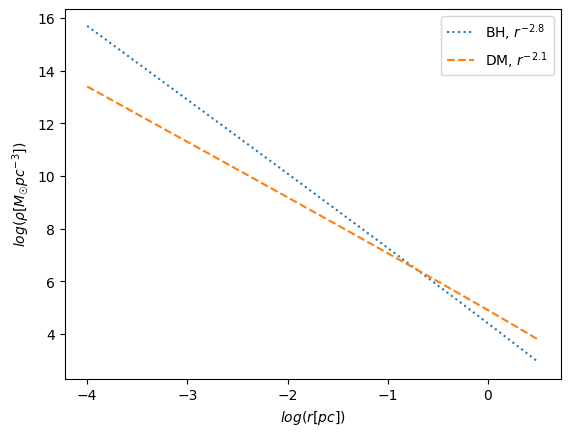

In [3]:
log_r = np.linspace(-4, 0.5)

f_bh = np.log(rho_bh(np.e**log_r))
f_dm = np.log(rho_dm(np.e**log_r))

plt.plot(log_r, f_bh, linestyle="dotted", label="BH, $r^{-2.8}$")
plt.plot(log_r, f_dm, linestyle="dashed", label="DM, $r^{-2.1}$")

plt.xlabel("$log(r[pc])$")
plt.ylabel(r"$log(\rho[M_{☉}pc^{-3}])$")

plt.legend()

Create potentials

In [4]:
def dist(x):
    return np.sqrt(np.sum(x**2, axis=1))


potential_bh = agama.Potential(
    type="Multipole", density=lambda x: rho_bh(dist(x)), symmetry="s"
)
potential_dm = agama.Potential(
    type="Multipole", density=lambda x: rho_dm(dist(x)), symmetry="s"
)

In [5]:
df_bh = agama.DistributionFunction(type="QuasiSpherical", potential=potential_bh)
df_dm = agama.DistributionFunction(type="QuasiSpherical", potential=potential_dm)

# df_bh = agama.DistributionFunction(type='DoublePowerLaw', norm=1, slopeIn=1, slopeOut=5, J0=1)
# df_dm = agama.DistributionFunction(type='DoublePowerLaw', norm=1, slopeIn=1, slopeOut=5, J0=1)

df_bh.totalMass(), df_dm.totalMass()

(3900266851070.533, 15830.848632147725)

In [6]:
model_bh = agama.GalaxyModel(potential=potential_bh, df=df_bh)
model_dm = agama.GalaxyModel(potential=potential_dm, df=df_dm)

### Choose model and simulation type

In [7]:
use_self_consistent_model = False
use_bh_model = True
N = 10_000  # the number of simulated particles in a cluster

In [8]:
def create_self_consistent_model(potential, df, verbose=False, plot=False):
    print("Creating a self-consistent model")
    dens = agama.Density(type="Plummer", mass=1.0, scaleRadius=1.0)

    # define the self-consistent model consisting of a single component
    params = dict(rminSph=0.001, rmaxSph=1000.0, sizeRadialSph=40, lmaxAngularSph=0)
    comp = agama.Component(df=df, density=dens, disklike=False, **params)
    scm = agama.SelfConsistentModel(**params)
    scm.components = [comp]

    # prepare visualization
    r = np.logspace(-4.0, 1.0)
    xyz = np.vstack((r, r * 0, r * 0)).T
    if plot:
        plt.plot(r, dens.density(xyz), label="Init density")
        plt.plot(r, potential.density(xyz), label="True density", c="k")[0].set_dashes(
            [4, 4]
        )

    # perform several iterations of self-consistent modelling procedure
    for i in range(10):
        scm.iterate()
        if verbose:
            print(
                "Iteration %i, Phi(0)=%g, Mass=%g"
                % (i, scm.potential.potential(0, 0, 0), scm.potential.totalMass())
            )
        if plot:
            plt.plot(r, scm.potential.density(xyz), label="Iteration #" + str(i))

    # save the final density/potential profile
    scm.potential.export("simple_scm.ini")

    if plot:
        # show the results
        plt.legend(loc="lower left")
        plt.xlabel("r")
        plt.ylabel(r"$\rho$")
        plt.xscale("log")
        plt.yscale("log")
        plt.ylim(1e2, 1e16)
        plt.xlim(1e-4, 1e1)
        plt.show()

    return scm

In [9]:
if use_bh_model:
    potential = potential_bh
    df = df_bh
else:
    potential = potential_dm
    df = df_dm


if use_self_consistent_model:
    # create and write out an N−body realization of the model
    scm = create_self_consistent_model(
        potential=potential,
        df=df,
        plot=True,
        verbose=False,
    )

    c_pot = scm.potential
    snap = agama.GalaxyModel(scm.potential, scm.potential.density).sample(N)
else:
    c_gm = agama.GalaxyModel(potential=potential, df=df)

    c_pot = potential
    snap = c_gm.sample(N)

## Perform an N-body simulation (without Milky Way)

In [10]:
# create an isolated star cluster
xv, m = snap[0], snap[1]

# shift it to some initial point in the Galaxy
c_center = np.hstack([0, 0, 0, 0, 0, 0])
xv += c_center

In [11]:
%%capture
%matplotlib inline

plt.rcParams["animation.html"] = "jshtml"
plt.rcParams["animation.embed_limit"] = 200

# Initialize plot and simulation parameters
fig = plt.figure(figsize=(10, 10), dpi=75)
ax = plt.axes([0.08, 0.08, 0.9, 0.9])

sim_time = 0.25 * 1  # total simulation time in units of kpc/(km/s) = 0.98 Gyr
num_intervals = 32 * 1
num_subint = 16
interval = sim_time / num_intervals


# Update plot at each iteration `i`
def update(i, ax, nbody_data, N):
    snap, c_bound, orbit_center, time = nbody_data[i]

    ax.cla()
    ax.scatter(
        snap[:, 0],
        snap[:, 1],
        c=c_bound,
        cmap="bwr_r",
        vmin=0,
        vmax=1,
        s=2,
        linewidths=0,
    )
    ax.plot(
        orbit_center[0 : i * num_subint, 0],
        orbit_center[0 : i * num_subint, 1],
        color="k",
    )
    ax.text(
        0.01,
        0.99,
        "time=%.4f, bound fraction=%.3f" % (time, np.sum(c_bound) * 1.0 / N),
        ha="left",
        va="top",
        transform=ax.transAxes,
    )

In [12]:
# calculate how cluster's center will move in its own potential
time_center, orbit_center = agama.orbit(
    potential=c_pot,
    ic=c_center,
    time=sim_time,
    trajsize=num_intervals * num_subint + 1,
)
cpot = c_pot
snap = xv.copy()

In [13]:
# Create a variable for simulation artifacts
nbody_data = {}

print("Start simulation...")

for i in trange(num_intervals + 1):  # Simulate `num_intervals` frames
    # determine which particles remain bound to the satellite
    c_bound = (
        cpot.potential(snap[:, 0:3] - orbit_center[i * num_subint, 0:3])
        + 0.5 * np.sum((snap[:, 3:6] - orbit_center[i * num_subint, 3:6]) ** 2, axis=1)
        < 0
    )
    time = i * interval

    # Fill `nbody_data`
    nbody_data[i] = (snap, c_bound, orbit_center, time)

    if i == num_intervals:
        continue

    # compute the trajectories of all particles moving in the combined potential of the host galaxy and the moving satellite
    snap = np.vstack(
        agama.orbit(
            ic=snap,
            potential=cpot,
            time=interval,
            timestart=time,
            trajsize=1,
            accuracy=1e-5,
            verbose=False,
        )[:, 1]
    )
    # update the potential of the satellite (using a spherical monopole approximation)
    cpot = agama.Potential(
        type="multipole",
        particles=(snap[:, 0:3] - orbit_center[(i + 1) * num_subint, 0:3], m),
        symmetry="s",
    )

Start simulation...


  0%|          | 0/33 [00:00<?, ?it/s]

RuntimeError: Error in creating potential: createExpGrid: invalid parameters

In [ ]:
snap

In [ ]:
ani = matplotlib.animation.FuncAnimation(
    fig=fig,
    func=partial(
        update,
        ax=ax,
        nbody_data=nbody_data,
        N=N,
        g_pot=g_pot,
    ),
    frames=num_intervals + 1,
    interval=250,
    cache_frame_data=False,
)

ani.save("sim.gif", writer="pillow")

In [ ]:
ani